In [1]:
import os
import sys

root_dir = os.path.join(os.getcwd(), '..')
sys.path.append(root_dir)

In [160]:
from collections import defaultdict
from flow_wmd.documents import Document
from flow_wmd.gale_shapeley import Matcher
from flow_wmd.models import LC_RWMD, WMD, WMDManyToMany, WMDPairs
from flow_wmd.utils import *

from gensim.models import KeyedVectors
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
from sklearn import cluster

import hdbscan
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import umap
import umap.plot

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1. Prepare IMDB data

### 1.1 Load data and stopwords.

In [4]:
PATH = "../data/"
imdb_data = pd.read_csv(f"{PATH}IMDB_Dataset.csv")
stopword_list=stopwords.words('english')

### 1.2 Remove special formatting and stopwords

In [175]:
tokenizer = RegexpTokenizer(r'\w+')

Remove stopwords before denoising, lemmatizing and removing special characters.

In [164]:
get_phrases([['testing', 'this', 'stuff'], ['yeah', 'what', 'is', 'up']])

[['testing', 'this', 'stuff'], ['yeah', 'what', 'is', 'up']]

In [177]:
%%time 

imdb_data['review_clean']= [remove_stopwords(r, stopword_list, tokenizer) for r in imdb_data['review_phrased']]

CPU times: user 2min 59s, sys: 5.3 s, total: 3min 4s
Wall time: 3min 14s


Denoise, remove special characters, lemmatize.

In [180]:
phrased_s = [" ".join(p) for p in imdb_data['review_phrased']]

In [6]:
%%time

imdb_data['review_clean']=imdb_data['review_clean'].apply(denoise_text)
imdb_data['review_clean']=imdb_data['review_clean'].apply(remove_special_characters)
imdb_data['review_clean']=imdb_data['review_clean'].apply(simple_lemmatizer)

CPU times: user 26.8 s, sys: 336 ms, total: 27.2 s
Wall time: 27.6 s


Remove stopwords again, after other preprocessing.

In [7]:
%%time 

imdb_data['review_clean']= [remove_stopwords(r, stopword_list, tokenizer) for r in imdb_data['review_clean']]

CPU times: user 21 s, sys: 188 ms, total: 21.2 s
Wall time: 21.7 s


Data _before_ preprocessing.

In [8]:
imdb_data['review'][0]

"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the fa

Data _after_ preprocessing.

In [9]:
imdb_data['review_clean'][0]

'one reviewer mentioned watching oz episode hooked right exactly happened first thing struck oz brutality unflinching scene violence set right word go trust show faint hearted timid show pull punch regard drug sex violence hardcore classic use word called oz nickname given oswald maximum security state penitentary focus mainly emerald city experimental section prison cell glass front face inwards privacy high agenda em city home many aryan muslim gangsta latino christian italian irish scuffle death stare dodgy dealing shady agreement never far away would say main appeal show due fact go show dare forget pretty picture painted mainstream audience forget charm forget romance oz mess around first episode ever saw struck nasty surreal say ready watched developed taste oz got accustomed high level graphic violence violence injustice crooked guard sold nickel inmate kill order get away well mannered middle class inmate turned prison bitch due lack street skill prison experience watching oz m

### 1.3 Separate pos and neg reviews

In [10]:
pos = imdb_data[imdb_data.sentiment == "positive"].reset_index(drop=True)
neg = imdb_data[imdb_data.sentiment == "negative"].reset_index(drop=True)

In [11]:
pos = pos.review_clean.tolist()
neg = neg.review_clean.tolist()

## 2. WMD

### 2.1 Tokenize and "sample" data

In [12]:
pos_tok = list(map(lambda x: tokenize(x, tokenizer), pos[:500]))
neg_tok = list(map(lambda x: tokenize(x, tokenizer), neg[:500]))

In [13]:
pos_sample = [" ".join(doc) for doc in pos_tok]
neg_sample = [" ".join(doc) for doc in neg_tok]

### 2.2 Load pretrained Google News W2V model

In [14]:
finetuned = True

In [15]:
if not finetuned:
    print("Loading GoogleNews Vectors")
    %time model = KeyedVectors.load_word2vec_format('../embeddings/GoogleNews-vectors-negative300.bin.gz', binary=True)
else:
    print("Loading GoogleNews Vectors finetuned using IMDB review data.")
    %time model = KeyedVectors.load_word2vec_format('../embeddings/imdb_w2v.txt', binary=False)

Loading GoogleNews Vectors finetuned using IMDB review data.
CPU times: user 12.6 s, sys: 495 ms, total: 13.1 s
Wall time: 13.8 s


### 2.3 Load corpus and remove OOV words

In [16]:
corpus = pos_sample + neg_sample

%time vectorizer = TfidfVectorizer(use_idf=False, tokenizer=tfidf_tokenize, norm='l1')
%time vectorizer.fit(corpus)

CPU times: user 62 µs, sys: 39 µs, total: 101 µs
Wall time: 107 µs


/Users/mikaelbrunila/Documents/Code/flow-wmd/venv-fwmd/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:489: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


CPU times: user 296 ms, sys: 12.8 ms, total: 309 ms
Wall time: 323 ms


TfidfVectorizer(norm='l1',
                tokenizer=<function tfidf_tokenize at 0x7f870e8f8ee0>,
                use_idf=False)

In [17]:
%time oov = [word for word in vectorizer.get_feature_names() if word not in model.key_to_index.keys()]

CPU times: user 15.5 ms, sys: 318 µs, total: 15.8 ms
Wall time: 16 ms


In [18]:
len(oov)

2037

In [19]:
%time pos_sample = list(map(lambda x: remove_oov(x, tokenizer, oov), pos_sample[:500]))
%time neg_sample = list(map(lambda x: remove_oov(x, tokenizer, oov), neg_sample[:500]))

CPU times: user 1.99 s, sys: 32.5 ms, total: 2.02 s
Wall time: 2.16 s
CPU times: user 1.93 s, sys: 35.4 ms, total: 1.96 s
Wall time: 2.06 s


In [20]:
pos_sample[0]

'one reviewer mentioned watching oz episode hooked right exactly happened first thing struck oz brutality unflinching scene violence set right word go trust show faint hearted timid show pull punch regard drug sex violence hardcore classic use word called oz nickname given oswald maximum security state penitentary focus mainly emerald city experimental section prison cell glass front face inwards privacy high agenda em city home many aryan muslim gangsta latino christian italian irish scuffle death stare dodgy dealing shady agreement never far away would say main appeal show due fact go show dare forget pretty picture painted mainstream audience forget charm forget romance oz mess around first episode ever saw struck nasty surreal say ready watched developed taste oz got accustomed high level graphic violence violence injustice crooked guard sold nickel inmate kill order get away well mannered middle class inmate turned prison bitch due lack street skill prison experience watching oz m

In [21]:
corpus = pos_sample + neg_sample

%time vectorizer = TfidfVectorizer(use_idf=True, tokenizer=tfidf_tokenize,norm='l1')
%time vectorizer.fit(corpus)

CPU times: user 26 µs, sys: 0 ns, total: 26 µs
Wall time: 29.1 µs
CPU times: user 250 ms, sys: 7.14 ms, total: 257 ms
Wall time: 260 ms


TfidfVectorizer(norm='l1',
                tokenizer=<function tfidf_tokenize at 0x7f870e8f8ee0>)

Bag-of-words vectorizer.

In [22]:
%time
pos_nbow = vectorizer.transform(pos_sample)
neg_nbow = vectorizer.transform(neg_sample)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.77 µs


In [23]:
pos_tok = list(map(lambda x: tokenize(x, tokenizer), pos_sample[:500]))
neg_tok =list(map(lambda x: tokenize(x, tokenizer), neg_sample[:500]))

In [24]:
pos_tok[0][:20]

['one',
 'reviewer',
 'mentioned',
 'watching',
 'oz',
 'episode',
 'hooked',
 'right',
 'exactly',
 'happened',
 'first',
 'thing',
 'struck',
 'oz',
 'brutality',
 'unflinching',
 'scene',
 'violence',
 'set',
 'right']

In [25]:
%time oov_ = [word for word in vectorizer.get_feature_names() if word not in model.key_to_index.keys()]

CPU times: user 27.9 ms, sys: 1.13 ms, total: 29 ms
Wall time: 31.6 ms


In [26]:
len(oov_)

0

### 2.4 Get features and embeddings

In [27]:
features = vectorizer.get_feature_names()
word2idx = {word: idx for idx, word in enumerate(vectorizer.get_feature_names())}
idx2word = {idx: word for idx, word in enumerate(vectorizer.get_feature_names())}

Get the embedding matrix "E" for all features.

In [28]:
E = np.vstack([model.get_vector(word) for word in vectorizer.get_feature_names()])

### 2.5 Cluster

In order to make the results of the WMD model more interpretable, we add the option to inspect the output not only by individual words, but also by *word clusters*. We do this by clustering the input words with two different algorithms
and assigning each word to a cluster.

#### 2.5.1 Kmeans

First, we get the embeddings for the words that are in our feature space.

In [30]:
X = model[features]

Then we select the number of clusters we want, initialize the Kmeans model and fit it.

In [70]:
%%time

K = range(5,105, 5)

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 9.06 µs


In [71]:
wvec_ssd, wvec_silhouette = kmeans_search(X, K)

For n_clusters = 5 The average silhouette_score is : -0.01671189
For n_clusters = 10 The average silhouette_score is : -0.013011397
For n_clusters = 15 The average silhouette_score is : -0.008803182
For n_clusters = 20 The average silhouette_score is : -0.0074520227
For n_clusters = 25 The average silhouette_score is : -0.0144842155
For n_clusters = 30 The average silhouette_score is : -0.09165746
For n_clusters = 35 The average silhouette_score is : -0.08887476
For n_clusters = 40 The average silhouette_score is : -0.091041364
For n_clusters = 45 The average silhouette_score is : -0.08933496
For n_clusters = 50 The average silhouette_score is : -0.09382486
For n_clusters = 55 The average silhouette_score is : -0.09412909
For n_clusters = 60 The average silhouette_score is : -0.0939522
For n_clusters = 65 The average silhouette_score is : -0.09028276
For n_clusters = 70 The average silhouette_score is : -0.084792
For n_clusters = 75 The average silhouette_score is : -0.09138381
For n_c

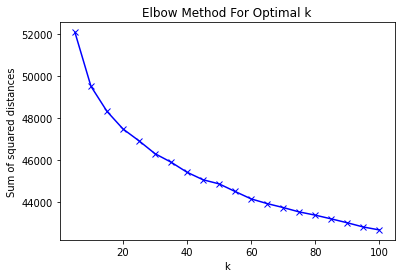

In [76]:
plot_kmeans(K,wvec_ssd,"elbow")

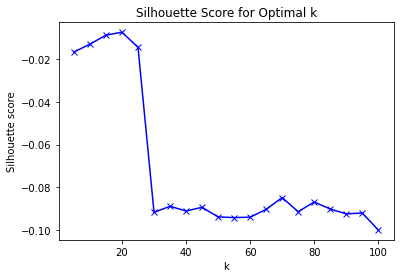

In [77]:
plot_kmeans(K,wvec_silhouette,"silhouette")

In [78]:
NUM_CLUSTERS = 50
kmeans = cluster.KMeans(n_clusters=NUM_CLUSTERS, verbose=0)
kmeans.fit(X)

KMeans(n_clusters=50)

Assign labels and centroids to separate variables for later use.

#### T-SNE

In [87]:
method='exact'
n_components = 50
verbose = 1

In [ ]:
X_tsne = TSNE(n_components=n_components, method=method, verbose=verbose).fit_transform(X)

#### PCA

In [90]:
from sklearn.decomposition import PCA


In [ ]:
n_components = 0.9
verbose = 1

In [ ]:
PCA()

In [102]:
pca_fit = PCA(n_components = 0.9).fit(X)

In [103]:
print(len(pca_fit.explained_variance_ratio_))
print(pca_fit.explained_variance_ratio_)
print(np.sum(pca_fit.explained_variance_ratio_))

167
[0.06435614 0.04909656 0.04438479 0.0368754  0.03407619 0.02659557
 0.02371854 0.02077031 0.01860685 0.01815131 0.01558423 0.01512059
 0.01462565 0.01320555 0.01243524 0.01153682 0.01132482 0.01038359
 0.00979714 0.00960583 0.00935004 0.0086311  0.00830186 0.00804729
 0.007957   0.00779462 0.0074152  0.00709255 0.00665893 0.00662771
 0.00656203 0.00635382 0.00615038 0.00592942 0.00563233 0.00553618
 0.0053863  0.00537179 0.00517492 0.00506727 0.00502274 0.00498525
 0.00490296 0.00486696 0.00467238 0.00463912 0.00460764 0.00446323
 0.00437344 0.00432273 0.00412675 0.00408652 0.00402012 0.00389187
 0.00384899 0.00384097 0.00379099 0.00373973 0.00371442 0.00366468
 0.00359082 0.00352815 0.00341475 0.00338755 0.00332852 0.00331692
 0.00323819 0.00318979 0.00318073 0.0031026  0.00306762 0.00303726
 0.00299008 0.00294669 0.00290414 0.00287498 0.00282201 0.00280944
 0.00278713 0.00276376 0.00270592 0.00266687 0.00262829 0.00260025
 0.00256797 0.00252402 0.00247378 0.00245932 0.00240563 0.

In [104]:
X_pca = pca_fit.transform(X)

In [105]:
pca_ssd, pca_silhouette = kmeans_search(X_pca, K)

For n_clusters = 5 The average silhouette_score is : -0.009149419
For n_clusters = 10 The average silhouette_score is : -0.003199471
For n_clusters = 15 The average silhouette_score is : 0.002512015
For n_clusters = 20 The average silhouette_score is : 0.0063623106
For n_clusters = 25 The average silhouette_score is : -0.08804091
For n_clusters = 30 The average silhouette_score is : -0.079224974
For n_clusters = 35 The average silhouette_score is : -0.07614847
For n_clusters = 40 The average silhouette_score is : -0.07653101
For n_clusters = 45 The average silhouette_score is : -0.07736571
For n_clusters = 50 The average silhouette_score is : -0.07149592
For n_clusters = 55 The average silhouette_score is : -0.07383971
For n_clusters = 60 The average silhouette_score is : -0.06866626
For n_clusters = 65 The average silhouette_score is : -0.08096953
For n_clusters = 70 The average silhouette_score is : -0.083923765
For n_clusters = 75 The average silhouette_score is : -0.07499548
For n_

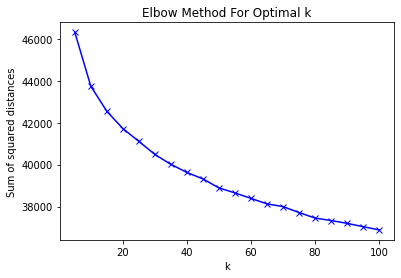

In [106]:
plot_kmeans(K,pca_ssd,"elbow")

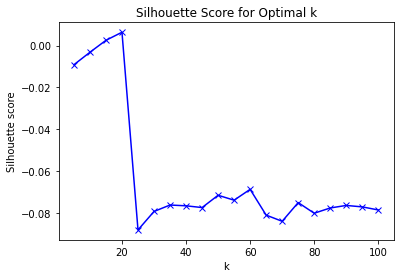

In [107]:
plot_kmeans(K,pca_silhouette,"silhouette")

#### UMAP

In [35]:
from scipy.spatial.distance import is_valid_dm, cdist

In [36]:
metric = 'cosine'
dm = cdist(X, X, metric)
np.fill_diagonal(dm, 0)

In [38]:
is_valid_dm(dm)

True

In [39]:
mean, std = np.mean(dm), np.std(dm)
print(mean, std)

0.5463798013772899 0.15759518394857022


In [116]:
min_dist=mean - 3*std
n_neighbors = int(0.005*len(X))
n_components=100
print(f"Min distance: {min_dist}")
print(f"N. neighbors: {n_neighbors}")
print(f"N. compontents: {n_components}")

Min distance: 0.07359424953157923
N. neighbors: 73
N. compontents: 100


In [117]:
umap_vecs = umap.UMAP(
    n_neighbors=n_neighbors,
    min_dist=min_dist,
    n_components=n_components,
    random_state=42,
).fit_transform(X)

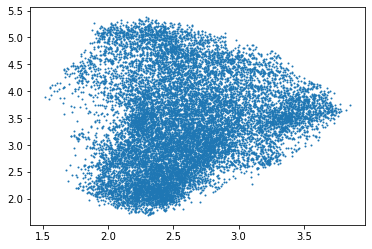

In [118]:
plt.scatter(umap_vecs[:, 0], umap_vecs[:, 1], s=1);

In [119]:
umap_ssd, umap_silhouette = kmeans_search(umap_vecs, K)

For n_clusters = 5 The average silhouette_score is : 0.32266316
For n_clusters = 10 The average silhouette_score is : 0.27443713
For n_clusters = 15 The average silhouette_score is : 0.25729528
For n_clusters = 20 The average silhouette_score is : 0.24993949
For n_clusters = 25 The average silhouette_score is : 0.24641766
For n_clusters = 30 The average silhouette_score is : 0.23906784
For n_clusters = 35 The average silhouette_score is : 0.23007481
For n_clusters = 40 The average silhouette_score is : 0.2222808
For n_clusters = 45 The average silhouette_score is : 0.22558367
For n_clusters = 50 The average silhouette_score is : 0.220038
For n_clusters = 55 The average silhouette_score is : 0.21421985
For n_clusters = 60 The average silhouette_score is : 0.21789761
For n_clusters = 65 The average silhouette_score is : 0.21348593
For n_clusters = 70 The average silhouette_score is : 0.21423313
For n_clusters = 75 The average silhouette_score is : 0.21617328
For n_clusters = 80 The avera

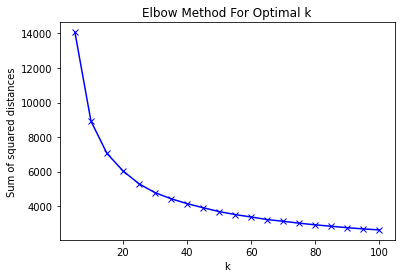

In [120]:
plot_kmeans(K,umap_ssd,"elbow")

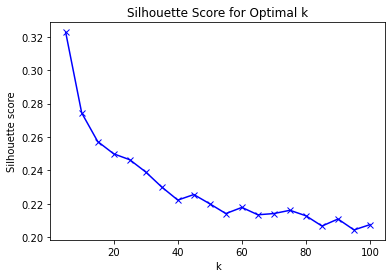

In [121]:
plot_kmeans(K,umap_silhouette,"silhouette")

In [ ]:
#hdbscan_labels = hdbscan.HDBSCAN(min_samples=10, min_cluster_size=500).fit_predict(lowd_X)

#### 2.5.4 Choose clustering model

In [148]:
cluster_algo = 'kmeans'
k = 50

In [149]:
if cluster_algo == 'kmeans':
    km = cluster.KMeans(n_clusters=k,max_iter=300).fit(X)
    
if cluster_algo == 'kmeans_pca':
    km = cluster.KMeans(n_clusters=k,max_iter=300).fit(X_pca)
    
if cluster_algo == 'kmeans_umap':
    km = cluster.KMeans(n_clusters=k,max_iter=300).fit(umap_vecs)
    
labels = km.labels_
centroids = km.cluster_centers_

Create an index that maps each word to a cluster.

In [150]:
word2cluster = {features[idx]: cl for idx, cl in enumerate(labels)}

In [151]:
print(take(10, word2cluster.items()))

[('aaargh', 26), ('aaliyah', 26), ('aamir', 36), ('aaron', 24), ('ab', 26), ('abandon', 14), ('abandoned', 0), ('abba', 35), ('abbey', 46), ('abbot', 46)]


Now, conversely, create an index that maps each cluster to a word.

In [152]:
cluster2words = defaultdict(list)
for key, value in word2cluster.items():
    cluster2words[value].append(key)

In [153]:
print(cluster2words[0][:100])

['abandoned', 'adjacent', 'airport', 'alabama', 'alaska', 'apartment', 'area', 'arrival', 'arrive', 'arriving', 'atlanta', 'atlantic', 'attend', 'attending', 'banquet', 'bar', 'bay', 'beach', 'blitz', 'block', 'boston', 'brooklyn', 'budapest', 'buffalo', 'bulgaria', 'bus', 'bustling', 'busy', 'ca', 'cabin', 'cafe', 'california', 'campus', 'canyon', 'caravan', 'caribbean', 'cattle', 'celebrate', 'celebrating', 'center', 'centre', 'ceremony', 'chicago', 'city', 'club', 'coal', 'coast', 'columbus', 'conference', 'confines', 'cottage', 'countryside', 'county', 'cramped', 'creek', 'crowded', 'decaying', 'decrepit', 'denver', 'desert', 'desolate', 'destination', 'diner', 'district', 'dive', 'dorm', 'downtown', 'drive', 'estate', 'exotic', 'factory', 'farm', 'ferry', 'fishing', 'fled', 'flee', 'fleeing', 'florida', 'foggy', 'forest', 'funeral', 'georgia', 'globe', 'harbor', 'harlem', 'hawaii', 'heading', 'highway', 'holiday', 'home', 'hometown', 'hotel', 'house', 'housing', 'houston', 'idylli

### 2.6 Initialize documents

Transform all reviews into "documents", each with a set of weights per word in the corpus ("nbow"), the sum of these weights ("weights_sum"), the indeces of the words in the documents ("idxs") and the word vectors corresponding to each word ("vecs").

In [252]:
pos_nbow[0]

<1x14766 sparse matrix of type '<class 'numpy.float64'>'
	with 133 stored elements in Compressed Sparse Row format>

In [253]:
%%time 

pos_docs, neg_docs = [], []

for idx, doc in enumerate(pos_tok):
    pos_docs.append(Document(doc, pos_nbow[idx], word2idx, E))
    
for idx, doc in enumerate(neg_tok):
    neg_docs.append(Document(doc, neg_nbow[idx], word2idx, E))

CPU times: user 220 ms, sys: 61.8 ms, total: 282 ms
Wall time: 282 ms


In [254]:
pos_docs[0].nbow

array([[0., 0., 0., ..., 0., 0., 0.]])

In [255]:
pos_docs[0].weights_sum

1.0

In [256]:
pos_docs[0].idxs[:10]

[9728, 13334, 9238, 10277, 6187, 4652, 6699, 10286, 2094, 6701]

In [257]:
pos_docs[0].vecs[:1][0][:10]

array([-0.03184877,  0.08938561, -0.23239496, -0.22144787,  0.00298812,
       -0.16498049, -0.1524208 ,  0.21617717, -0.37542573,  0.06170934],
      dtype=float32)

### 2.7 Linear-Complexity Relaxed WMD (LC-RWMD)

Run the [Linear-Complexity Relaxed WMD](https://arxiv.org/abs/1711.07227) to get the distances between all positive and all negative reviews.

In [77]:
%time lc_rwmd = LC_RWMD(pos_docs, neg_docs,pos_nbow,neg_nbow,E)
%time lc_rwmd.get_D()
#%time lc_rwmd.get_L(1)
#%time lc_rwmd.get_rwmd()

CPU times: user 13 µs, sys: 12 µs, total: 25 µs
Wall time: 28.8 µs
CPU times: user 2min 22s, sys: 21 s, total: 2min 43s
Wall time: 42.8 s


### 2.8 Gale-Shapeley Pairing

Use the [Gale-Shapeley matching algorithm](https://en.wikipedia.org/wiki/Gale%E2%80%93Shapley_algorithm) to find the optimal pairs between positive and negative reviews. This iterates over all the reviews and finds the set of matches that pairs each review with its optimal match given that all positive reviews have to be matched with a negative review and vice versa. The output is a dictionary of key-value pairs, where each pair represents an optimal match.

In [127]:
%%time

matcher = Matcher(lc_rwmd.D)
engaged = matcher.matchmaker()
matcher.check()
pairs = engaged

CPU times: user 1.05 s, sys: 19.3 ms, total: 1.07 s
Wall time: 1.08 s


Let's look at the output of Gale-Shapeley:

In [128]:
take(10, pairs.items())

[(185, 299),
 (35, 473),
 (336, 28),
 (188, 248),
 (101, 148),
 (253, 15),
 (133, 258),
 (104, 259),
 (131, 377),
 (107, 10)]

In [129]:
example_pairs = [(' '.join(word for word in pos_docs[p[0]].words), 
                  ' '.join(word for word in neg_docs[p[1]].words))
                 for p in take(10, pairs.items())]

In [134]:
example_pairs[9][0]

'game rank far honor playing mine p graphic really good voice acting standard difficulty level right best character series opinion story amazed took many different twist expecting rating game deserves great'

In [135]:
example_pairs[9][1]

'terrible misfortune view entirety say save time money got worst time even called like fails aspect make good movie story interesting actor believable bad direction action sequence fake almost funny almost movie packed full crappy oneliners respectable person could find amusing least little bit movie supposed geared towards men woman utterly unattractive especially old wrinkled thing come towards end try appear sexy weird horrible costume fail miserably even ridiculous still give laugh painful watch'

### 2.9 Pairwise WMD

Calculate the pairwise distances between the documents selected by the Galey-Shapeley algorithm _without_ returning the flow between individual words.

In [174]:
%%time 

wmd_pairs = WMDPairs(pos_docs,neg_docs,pairs,E,idx2word)
wmd_pairs.get_distances(thread=False)

Calculated distances between 0 documents.
Calculated distances between 100 documents.
Calculated distances between 200 documents.
Calculated distances between 300 documents.
Calculated distances between 400 documents.
CPU times: user 2min 26s, sys: 13.4 s, total: 2min 39s
Wall time: 1min 9s


The return value is a matrix of distances between the document pairs.

In [175]:
wmd_pairs.distances

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

Calculate the pairwise distances between the documents selected by the Galey-Shapeley algorithm, this time also returning the flow between individual words.

In [279]:
%%time 

wmd_pairs_flow = WMDPairs(pos_docs,neg_docs,pairs,E,idx2word)
wmd_pairs_flow.get_distances(return_flow = True, 
                             sum_clusters = True, 
                             w2c = word2cluster, 
                             c2w = cluster2words,
                             thread = True)

Calculated distances between approximately 0 documents.
Calculated distances between approximately 100 documents.
Calculated distances between approximately 200 documents.
Calculated distances between approximately 300 documents.
Calculated distances between approximately 400 documents.
CPU times: user 2min 9s, sys: 12.7 s, total: 2min 22s
Wall time: 1min 13s


Now we have three return values.

The first one is again a matrix of distances between the document pairs.

In [280]:
wmd_pairs_flow.distances

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

The second return value is a list of tuples with all the words that contributed the most to the distance from the positive documents to the negative ones. These are _not_ sorted from high to low or vice versa.

In [281]:
take(10, wmd_pairs_flow.wc_X1.items())

[('youtube', 0.09996),
 ('interest', 0.6890999999999999),
 ('bumping', 0.02748),
 ('amateur', 0.07795),
 ('abbreviated', 0.0189),
 ('frisky', 0.02511),
 ('renovated', 0.03214),
 ('cue', 0.00858),
 ('drive', 0.31423),
 ('keaton', 0.1514)]

The third return value is a list of tuples with all the words that contributed the most to the distance from the negative documents to the positive ones. Again, these are _not_ sorted from high to low or vice versa.

In [282]:
take(10, wmd_pairs_flow.wc_X2.items())

[('youtube', 0.00701),
 ('interest', 1.0196800000000001),
 ('superstar', 0.029),
 ('amateur', 0.17423),
 ('critique', 0.19007000000000002),
 ('tremaine', 0.022299999999999997),
 ('skiing', 0.03281),
 ('shabby', 0.03551),
 ('effeminate', 0.04624),
 ('abbreviated', 0.01819)]

In [283]:
take(10, wmd_pairs_flow.cc_X1.items())

[(47, 26.87340000000001),
 (35, 27.0506),
 (9, 64.89536999999989),
 (49, 28.077189999999998),
 (37, 31.38593),
 (2, 33.3449),
 (29, 21.751929999999998),
 (5, 20.562499999999993),
 (4, 12.16579999999999),
 (28, 53.41627000000003)]

In [284]:
take(10, wmd_pairs_flow.cc_X2.items())

[(47, 30.202939999999995),
 (35, 17.82964000000001),
 (9, 47.355790000000056),
 (49, 17.861280000000004),
 (37, 24.013939999999995),
 (2, 28.788590000000003),
 (29, 11.434670000000002),
 (5, 21.04724),
 (4, 11.866719999999995),
 (28, 48.22412000000002)]

In [285]:
{k: v for k, v in sorted(wmd_pairs_flow.cc_X1.items(), key=lambda item: item[1], reverse=True)[:10]}

{36: 161.58907000000002,
 8: 81.38867000000009,
 16: 70.82005999999987,
 9: 64.89536999999989,
 7: 64.30552,
 48: 63.50652000000012,
 18: 62.74714999999987,
 20: 60.77309999999992,
 17: 54.14427000000003,
 28: 53.41627000000003}

In [286]:
wmd_pairs_flow.get_differences()

### 3.1 Intepreting pairwise WMD flows

Now, let's sort the distances of the words that created the most distance from the positive to the negative reviews.

In [287]:
{k: v for k, v in sorted(wmd_pairs_flow.wc_X1_diff.items(), key=lambda item: item[1], reverse=True)[:30]}

{'great': 3.6841199999999983,
 'love': 3.0659199999999993,
 'best': 2.9734699999999994,
 'young': 2.7412799999999993,
 'still': 2.678639999999999,
 'performance': 2.4275899999999995,
 'excellent': 2.3056899999999994,
 'game': 2.0037299999999996,
 'loved': 1.9073000000000002,
 'favorite': 1.89277,
 'wonderful': 1.8905500000000002,
 'well': 1.8735199999999992,
 'little': 1.7632000000000012,
 'dvd': 1.6582800000000009,
 'life': 1.63394,
 'family': 1.6094199999999996,
 'song': 1.47339,
 'perfect': 1.42944,
 'story': 1.3294199999999998,
 'role': 1.32804,
 'brilliant': 1.3100100000000001,
 'italian': 1.24688,
 'new': 1.2368199999999991,
 'man': 1.195279999999999,
 'beautiful': 1.1913199999999997,
 'always': 1.1709999999999998,
 'enjoy': 1.1691700000000005,
 'father': 1.1628600000000002,
 'romantic': 1.14786,
 'amazing': 1.1355700000000002}

Next, let's see what added most distance when moving from the negative to the positive reviews.

In [288]:
{k: v for k, v in sorted(wmd_pairs_flow.wc_X2_diff.items(), key=lambda item: item[1], reverse=True)[:30]}

{'bad': 7.070259999999994,
 'worst': 4.54303,
 'waste': 3.59436,
 'money': 2.8272600000000008,
 'even': 2.721729999999997,
 'stupid': 2.58822,
 'awful': 2.4731899999999998,
 'ever': 2.3345599999999997,
 'boring': 2.2304399999999993,
 'movie': 2.1923999999999975,
 'terrible': 2.1853499999999992,
 'plot': 2.10646,
 'poor': 2.1032800000000003,
 'guy': 1.9638899999999995,
 'instead': 1.9381299999999992,
 'acting': 1.905740000000001,
 'rating': 1.85195,
 'nothing': 1.8448299999999993,
 'rent': 1.7515500000000002,
 'could': 1.7412000000000019,
 'made': 1.6352300000000008,
 'least': 1.5719700000000012,
 'horrible': 1.5380399999999999,
 'supposed': 1.4540500000000003,
 'say': 1.442960000000001,
 'worse': 1.4196200000000003,
 'better': 1.4166099999999986,
 'hour': 1.348899999999999,
 'minute': 1.3478999999999997,
 'dull': 1.29528}

Finally, let's look at the distances between the two sets by clustering similar words, in order to get a better sense of what kind of "topics" that separate them. Each cluster has a weight that matches the sum of the words belonging to that cluster. We choose *n* top clusters to inspect. To make the clusters interpretable, we also represent each of them by *m* keywords, selected based on the cost they individually add between the two sets.

In [289]:
n_clusters = 50
n_words = 10

c1 = output_clusters(wc=wmd_pairs_flow.wc_X1_diff.items(), 
                     cc=wmd_pairs_flow.cc_X1.items(), 
                     c2w=cluster2words, 
                     n_clusters=n_clusters, 
                     n_words=n_words)
c2 = output_clusters(wc=wmd_pairs_flow.wc_X2_diff.items(), 
                     cc=wmd_pairs_flow.cc_X2.items(), 
                     c2w=cluster2words, 
                     n_clusters=n_clusters, 
                     n_words=n_words)

Positive to negative clusters.

In [290]:
c1

,36,8,16,9,7,48,18,20,17,28,...,43,27,23,11,0,4,15,3,39,40
0,still (2.68),loved (1.91),new (1.24),performance (2.43),easy (0.93),great (3.68),best (2.97),little (1.76),story (1.33),favorite (1.89),...,extremely (0.53),khan (0.34),identity (0.47),universe (0.35),italian (1.25),knotts (0.34),fulci (0.47),stupidest (0.25),black (0.23),game (2.0)
1,enjoy (1.17),later (0.71),take (0.89),well (1.87),message (0.89),excellent (2.31),greatest (0.84),yet (0.73),theme (0.74),entertaining (1.1),...,mundane (0.17),tessa (0.25),witness (0.25),build (0.29),russian (0.24),stone (0.21),plenty (0.33),pap (0.04),white (0.18),None
2,liked (0.95),enjoyed (0.66),keep (0.84),role (1.33),lesson (0.56),wonderful (1.89),star (0.71),particularly (0.72),different (0.57),definitely (1.03),...,corny (0.17),helena (0.23),jail (0.24),space (0.24),foreign (0.15),darius (0.18),flesh (0.19),putrid (0.04),color (0.0),None
3,hard (0.95),time (0.59),hope (0.8),always (1.17),question (0.52),perfect (1.43),cinema (0.71),often (0.7),follows (0.46),disney (1.02),...,dated (0.17),davy (0.21),illegal (0.22),wave (0.22),hindi (0.15),meatball (0.16),brutal (0.19),agonizing (0.02),None,None
4,real (0.73),glad (0.54),help (0.59),job (1.07),change (0.46),brilliant (1.31),special (0.64),nice (0.66),within (0.39),adventure (0.97),...,tolerable (0.17),kimberly (0.19),police (0.2),scientific (0.16),polish (0.15),bela (0.16),graphic (0.16),abominable (0.02),None,None
5,awesome (0.7),found (0.52),future (0.46),especially (0.87),important (0.42),beautiful (1.19),major (0.63),although (0.64),beginning (0.36),comedy (0.83),...,hilariously (0.13),brook (0.14),suspect (0.2),spreading (0.15),french (0.15),zodiac (0.13),explicit (0.1),execrable (0.02),None,None
6,worth (0.63),impressed (0.5),live (0.4),comic (0.81),may (0.42),romantic (1.15),picture (0.6),plus (0.55),minor (0.34),fan (0.82),...,silly (0.12),hare (0.13),conspiracy (0.17),route (0.15),british (0.14),greeting (0.13),slasher (0.1),load (0.02),None,None
7,wish (0.58),remember (0.46),working (0.39),play (0.72),justice (0.4),amazing (1.14),thanks (0.58),typical (0.5),event (0.34),favourite (0.77),...,dodgy (0.1),beverly (0.13),suicide (0.16),aboard (0.15),term (0.11),immobile (0.12),satisfy (0.1),plague (0.01),None,None
8,doubt (0.51),watched (0.45),move (0.39),supporting (0.64),whether (0.36),incredible (1.06),gem (0.57),romance (0.49),solution (0.32),classic (0.74),...,preachy (0.1),reg (0.13),detective (0.13),vault (0.14),greek (0.09),abbot (0.11),hardcore (0.1),ugh (0.0),None,None
9,rocked (0.36),thought (0.45),break (0.38),playing (0.52),matter (0.35),superb (0.94),today (0.52),quite (0.45),flaw (0.29),animated (0.58),...,unreal (0.09),cervi (0.13),trial (0.13),treasure (0.13),translation (0.09),hound (0.11),duckling (0.1),endure (-0.02),None,None


Negative to positive clusters.

In [291]:
c2 

,36,8,16,7,3,17,20,18,43,28,...,24,31,6,0,4,29,21,27,39,40
0,even (2.72),got (1.28),money (2.83),god (1.2),bad (7.07),plot (2.11),action (1.16),made (1.64),boring (2.23),better (1.42),...,army (0.43),horror (0.88),chase (0.27),accent (0.38),wood (0.26),dancing (0.37),sweden (0.22),vargas (0.22),colour (0.16),game (-2.0)
1,ever (2.33),seemed (1.23),save (1.27),understand (0.89),worst (4.54),whole (0.98),pretty (0.99),making (0.78),dull (1.3),original (0.68),...,heist (0.23),nightmare (0.56),fight (0.26),indian (0.34),ali (0.21),listening (0.32),urban (0.18),de (0.12),color (-0.0),None
2,movie (2.19),bored (1.17),try (1.06),obviously (0.74),waste (3.59),idea (0.96),unfortunately (0.69),credit (0.63),depressing (1.06),title (0.67),...,former (0.22),scary (0.32),wing (0.19),speak (0.32),karmen (0.17),sing (0.2),canada (0.17),franz (0.11),white (-0.18),None
3,nothing (1.84),went (1.03),go (0.74),fact (0.67),stupid (2.59),end (0.88),otherwise (0.58),effort (0.62),poorly (1.05),sequel (0.64),...,warden (0.21),dentist (0.16),beating (0.19),english (0.26),appears (0.16),elvis (0.19),pakistani (0.16),kyra (0.11),black (-0.23),None
4,could (1.74),disappointed (0.76),trying (0.68),problem (0.67),awful (2.47),begin (0.83),overall (0.51),example (0.49),badly (0.83),csi (0.5),...,corrupt (0.2),shocker (0.16),mode (0.13),korean (0.24),annakin (0.14),rock (0.15),cuba (0.13),carver (0.1),None,None
5,least (1.57),tried (0.75),stay (0.58),attempt (0.57),terrible (2.19),premise (0.73),sort (0.5),project (0.49),unbelievable (0.71),laurel (0.46),...,agent (0.2),creepy (0.15),speed (0.12),native (0.17),ram (0.14),club (0.12),wwi (0.12),chen (0.1),None,None
6,supposed (1.45),wanted (0.7),get (0.49),express (0.57),poor (2.1),quickly (0.55),almost (0.49),pity (0.36),unrealistic (0.7),b (0.45),...,company (0.19),creep (0.15),hercules (0.12),non (0.14),jumbo (0.13),rap (0.1),st (0.11),fong (0.09),None,None
7,say (1.44),seen (0.68),make (0.43),contain (0.55),horrible (1.54),forward (0.54),relentlessly (0.46),sadly (0.32),weak (0.69),watchable (0.38),...,target (0.16),scared (0.14),contest (0.11),spoken (0.14),casbah (0.13),waltz (0.08),roman (0.11),sedgwick (0.09),None,None
8,really (1.27),hated (0.68),plan (0.42),blame (0.53),worse (1.42),entire (0.5),usually (0.45),hype (0.31),totally (0.68),parody (0.38),...,photographer (0.16),mysterious (0.14),zeus (0.1),hebrew (0.08),lounging (0.12),rehearsal (0.08),romanian (0.1),abo (0.09),None,None
9,anything (1.16),gave (0.59),receiving (0.4),simply (0.53),crap (1.24),point (0.46),remotely (0.36),failure (0.24),ridiculous (0.65),series (0.36),...,private (0.15),psycho (0.12),posse (0.1),canadian (0.07),hacker (0.11),ginger (0.07),southern (0.09),clifton (0.09),None,None


## Appendix: Many-to-many WMD

This was a first attempt to do the flows from words between many documents, without first filtering using Gale-Shapeley. However, this proved too inefficient. As you can see looking at the CPU times, it is very slow even with extremely small samples and the time complexity is quadratic (or worse?), meaning it rapidly gets even worse as the sample size increases.

In [155]:
%time m2m_distances = WMDManyToMany(pos_docs[:20], neg_docs[:20],E,idx2word).get_distances(return_flow = False)

CPU times: user 1min 48s, sys: 12.7 s, total: 2min 1s
Wall time: 50 s


In [156]:
%time m2m_distances_flow, wc_X1, wc_X2 = WMDManyToMany(pos_docs[:20],neg_docs[:20],E,idx2word).get_distances(return_flow = True)

CPU times: user 1min 52s, sys: 13.5 s, total: 2min 5s
Wall time: 51.4 s


In [157]:
{k: v for k, v in sorted(wc_X1.items(), key=lambda item: item[1], reverse=True)[:10]}

{'karen': 8.69223,
 'wrenching': 8.31882,
 'carpenter': 7.468960000000001,
 'laughter': 7.467879999999999,
 'liked': 6.864090000000003,
 'mom': 6.791519999999999,
 'gut': 6.759419999999999,
 'love': 6.551409999999997,
 'camp': 6.533080000000001,
 'hr': 6.1393699999999995}

In [158]:
{k: v for k, v in sorted(wc_X2.items(), key=lambda item: item[1], reverse=True)[:10]}

{'hopper': 8.372459999999998,
 'jake': 7.63837,
 'movie': 7.267059999999995,
 'film': 6.936379999999998,
 'shakespeare': 5.99276,
 'oddness': 5.53033,
 'terrible': 4.943440000000001,
 'parent': 4.751790000000001,
 'actor': 4.672620000000001,
 'bad': 4.430020000000002}